# Categorization Model Creation
In the following notebook, the operations data and corresponding clinical information are used to determine if the patient's Length of Stay is likely to be categorized as 'prolonged'
A prolonged legth of stay were determined previoulsy to be an LOS that exceed 1 stadard deviation from the mean for the given surgery type. Refer to Notebook [04.EDA](_src\04.EDA_4_outliers_impute.ipynb) for additional details or to revise the business rule. 


## Import Libraries

In [1]:
import os
from operator import itemgetter    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


### Import Data from Pre-Processing
* Missing values HAVE been imputed.
* No PCA performed yet, no 1hot encoding. 


In [2]:
######################
#
# Import Data from PreProcessing
#
#####################

df= pd.read_csv('../_data/operations_imputed_CLEAN_v2.csv', index_col=0)

df.drop(['race'], axis=1, inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76742 entries, 8 to 128030
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   op_id            76742 non-null  int64  
 1   subject_id       76742 non-null  int64  
 2   hadm_id          76742 non-null  int64  
 3   opdate           76742 non-null  int64  
 4   age              76742 non-null  int64  
 5   sex              76742 non-null  object 
 6   weight           76742 non-null  float64
 7   height           76742 non-null  float64
 8   asa              76742 non-null  float64
 9   department       76742 non-null  object 
 10  antype           76742 non-null  object 
 11  icd10_pcs        76742 non-null  object 
 12  category_desc    76742 non-null  object 
 13  desc_short       76742 non-null  object 
 14  category_id      76742 non-null  object 
 15  hr               76742 non-null  float64
 16  pip              76742 non-null  float64
 17  pmean           

### Create the X and y DataFrames for CATEGORICAL Model

  * create y
  * create X (complete with all the features)
  * drop the features we identified as not meeting impact threshold.
  * Target = `prolonged_LOS` (0 or 1) 



In [4]:
# When doing a Categorical Model, reinsert 'prolonged_LOS' and instead, drop 'LOS'

## Features to retain are those in X that will be used in training. Exludued features are features such as Operation_ID, Subject_ID..
features_to_retain = ['category_id','age','sex',	'weight',	'height',	'hr',	'pip',	'pmean',	'rr',	'spo2',	'vt',	'chloride',	'creatinine',	'glucose',	'hb',	'hco3',	'lymphocyte',	'platelet',	'potassium',	'sodium',	'total_bilirubin',	'wbc',	'icu_visit',	'or_duration',	'anesth_duration',	'department','antype'] 

## Create the Y, the Target
y = df['prolonged_LOS']

## Create X the Features for Train/Test/Validate
X = df.drop('prolonged_LOS', axis=1)
X= X[features_to_retain]

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76742 entries, 8 to 128030
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category_id      76742 non-null  object 
 1   age              76742 non-null  int64  
 2   sex              76742 non-null  object 
 3   weight           76742 non-null  float64
 4   height           76742 non-null  float64
 5   hr               76742 non-null  float64
 6   pip              76742 non-null  float64
 7   pmean            76742 non-null  float64
 8   rr               76742 non-null  float64
 9   spo2             76742 non-null  float64
 10  vt               76742 non-null  float64
 11  chloride         76742 non-null  float64
 12  creatinine       76742 non-null  float64
 13  glucose          76742 non-null  float64
 14  hb               76742 non-null  float64
 15  hco3             76742 non-null  float64
 16  lymphocyte       76742 non-null  float64
 17  platelet        

### Identify Features to be either cast as Str or Scaled

In [5]:
###########################################################
#
#  Identify the columns that need to be either cast as Str or Scaled
#
############################################################

#Category Columns that will need encoding. Cast them as String
COLS_TO_CAST = ['category_id','antype','sex','department', 'icu_visit']  #When restoring scope to full category list, add cat_id here.
                                                            # Convert the object data type columns to string

X[COLS_TO_CAST] = X[COLS_TO_CAST].astype(str)

# Numerical Columns for Scaling. Filter columns with dtype 'numeric' for scaling later in the Pipleine
COLS_TO_SCALE = X.select_dtypes(include=['int', 'float']).columns


print(f'Category Cols to encode: {COLS_TO_CAST}')
print(f'Numerical Cols to scale: {COLS_TO_SCALE}')
X.info()

Category Cols to encode: ['category_id', 'antype', 'sex', 'department', 'icu_visit']
Numerical Cols to scale: Index(['age', 'weight', 'height', 'hr', 'pip', 'pmean', 'rr', 'spo2', 'vt',
       'chloride', 'creatinine', 'glucose', 'hb', 'hco3', 'lymphocyte',
       'platelet', 'potassium', 'sodium', 'total_bilirubin', 'wbc',
       'or_duration', 'anesth_duration'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 76742 entries, 8 to 128030
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category_id      76742 non-null  object 
 1   age              76742 non-null  int64  
 2   sex              76742 non-null  object 
 3   weight           76742 non-null  float64
 4   height           76742 non-null  float64
 5   hr               76742 non-null  float64
 6   pip              76742 non-null  float64
 7   pmean            76742 non-null  float64
 8   rr               76742 non-null  float64

## Training-Test-Validation Split

- Training Set (80% of total): 
  - Used to train the models.
- Validation Set (20% of Traning Set ): 
  - Used to fine-tune hyperparameters, select models, and monitor training progress.  
- Testing Set (20% of total): 
  - Used to evaluate the final model's performance on unseen data and estimate its generalization performance.
- Given this is a CATEGORICAL model, use `stratify` to mitigate any class imbalance in split.

In [6]:
from sklearn.model_selection import train_test_split

TEST_SPLIT = .2
TRAINING_SPLIT = 1-TEST_SPLIT
VALIDATION_SPLIT = .2

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, stratify=y, random_state=85100)

# Split the Training AGAIN into train and Validate
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=TEST_SPLIT, random_state=85100)

# use X_train and y_train for model training and X_val and y_val for turning.

data_subset_dict = {
    'X_train': X_train,
    'X_validate': X_validate,
    'X_test': X_test,
    'y_train': y_train,
    'y_validate': y_validate,
    'y_test': y_test}

for key, value in data_subset_dict.items():
    shape = value.shape
    print(f"{key} shape: {shape}")


X_train shape: (49114, 27)
X_validate shape: (12279, 27)
X_test shape: (15349, 27)
y_train shape: (49114,)
y_validate shape: (12279,)
y_test shape: (15349,)


## Scale X (Numerical)
* We do NOT scale Y, the target
* We fit the StandardScaler on X_training and then transform both your training and validation sets

In [7]:
##### 
## SCALE X_train and X_validate
#########
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
                ('num', StandardScaler(), COLS_TO_SCALE)
                ],
    remainder='passthrough')  # Leaves the rest of the columns alone

# Fit on the training data
preprocessor.fit(X_train)

# Transform the training and validation data
X_train_scaled = preprocessor.transform(X_train)
X_validate_scaled = preprocessor.transform(X_validate)

# Now X_train_scaled and X_validate_scaled have the specified columns scaled, and the rest are unchanged

## MODEL

### Data Frame for the Evaluation measures

* We will be creating a number of metrics through the various models. 
* Create a dataframe (ie table) to maintain all these measures. 
* Update the table with the measures automatically when evaluation is completed. 

In [8]:
result_data = pd.DataFrame(columns = ["Model_Name","Sensitivity", "Specificity", "Accuracy"])

### Logistic Regression - Baseline

In [9]:
#########################
#
#  SIMPLE LOGISTIC REGRESSION Pipeline -
#  -- No tuning. 
########################

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

categorical_transform = Pipeline([('one-hot-encode', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

preprocessing_df = ColumnTransformer([('categorical', categorical_transform, COLS_TO_CAST)])

category_model_base = Pipeline([('preprocessing', preprocessing_df),
                          ('model', LogisticRegression())])
category_model_base.fit(X_train, y_train)

y_pred_log = category_model_base.predict(X_validate)

##### Evaluate Model

accuracy = accuracy_score(y_validate, y_pred_log)

print(f'Accuracy of base model: {accuracy}')
# print(f"RMSE of the base model: {:.3f}")




Accuracy of base model: 0.82465998859842


### Define Confusion Matrix Function

1. Define the confusion matrix
2. append the specificity/sensitivity/accuracy to the "results_data" dataframe
   

In [10]:
# Confusion Matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def plot_confusion_matrix(y_true, y_pred,modelname="Model"):
    print("True labels:")
    print(y_true)
    print("\nPredicted labels:")
    print(y_pred)
    
    
    
    accuracy = round(accuracy_score(y_true, y_pred), 2)
    cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
    
    
    sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.title("Accuracy Score: {0}".format(accuracy), size=10)
    plt.show()

    # Extract values from the confusion matrix
    TN, FP, FN, TP = cm.ravel()

    # Calculate Sensitivity (True Positive Rate)
    sensitivity = TP / (TP + FN)

    # Calculate Specificity (True Negative Rate)
    specificity = TN / (TN + FP)
    
    # Append the values to the Results DataFrame
    result_data.loc[len(result_data)] = [modelname,sensitivity, specificity,accuracy]
    
    print(classification_report(y_true, y_pred))
         
    return sensitivity, specificity, accuracy



### Implement Confusion Matrix for Logistic Regression

True labels:
116394    0
102011    0
11564     0
93856     1
47594     0
         ..
112235    0
14985     0
60829     0
95194     0
76465     0
Name: prolonged_LOS, Length: 12279, dtype: int64

Predicted labels:
[0 0 0 ... 0 0 0]


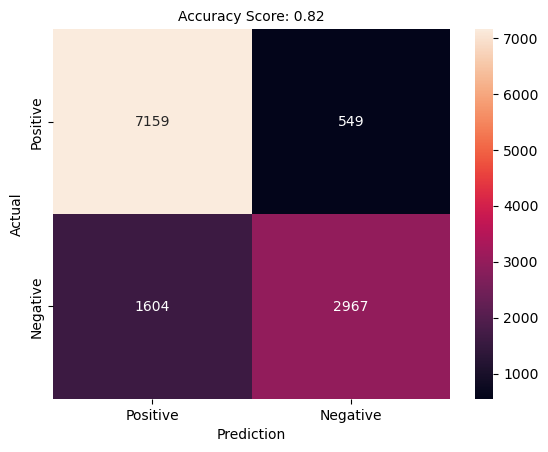

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      7708
           1       0.84      0.65      0.73      4571

    accuracy                           0.82     12279
   macro avg       0.83      0.79      0.80     12279
weighted avg       0.83      0.82      0.82     12279



,Model_Name,Sensitivity,Specificity,Accuracy
0,Logistic Regression,0.649092,0.928775,0.82


In [11]:
sensitivity_log, specificity_log, accuracy_log = plot_confusion_matrix(y_validate, y_pred_log, "Logistic Regression")  # Capture the returned values

result_data

In [ ]:
#### Reset the Results_data df while debugging.
result_data=result_data[0:0]

### Evaluation with ROC and AUC - Logistic Regression

The target feature in our scenario is binary (yes or no). The prediction output needs to reflect the probability of 1 instead of the values ( 0 or 1). This is acheived by using the `predict_prob` method (as opposed to the .predict)


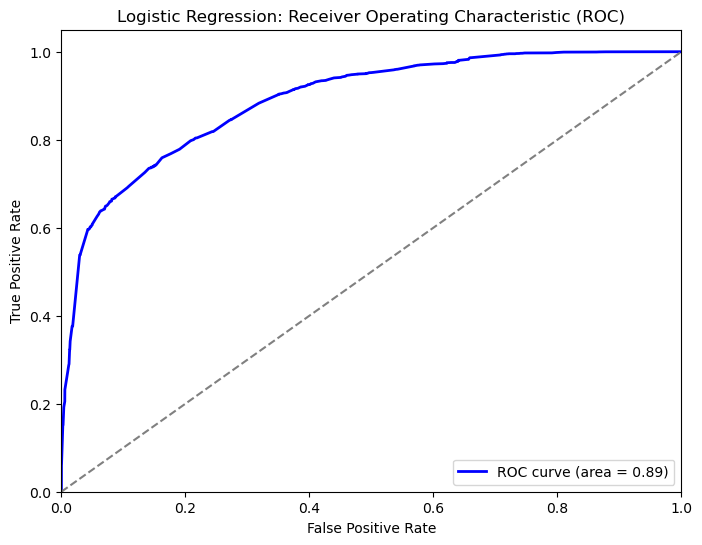

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score


## ROC Visualization 
Modelname = "Logistic Regression"
y_pred_prob_log = category_model_base.predict_proba(X_validate)[:, 1]

# Generate the ROC 
fpr, tpr, thresholds = roc_curve(y_validate, y_pred_prob_log)

# Calculate the Area Under Curve
roc_auc = roc_auc_score(y_validate, y_pred_prob_log)

# Graph it all together.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{Modelname}: Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn import set_config
set_config(display='diagram')
category_model_base

## Ensemble Models - Baselines  

Models employed:
* ExtraTreesClassifier
* Random Forest
* XGBRegressor
* CatBoost

In [13]:
#########################
#
#  Ensemble Pipeline -
#  -- No tuning. 
########################

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier,  ExtraTreesClassifier, BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model_list= [LogisticRegression(),ExtraTreesClassifier(n_jobs=-1),RandomForestClassifier(n_jobs=-1),XGBClassifier(n_jobs=-1)]
model_names = ["LogisticRegression","ExtraTreesClassifier", "RandomForestClassifier","XGBClassifier"]


ModScores = {}

categorical_transform = Pipeline([('one-hot-encode', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

preprocessing_df = ColumnTransformer([('categorical', categorical_transform, COLS_TO_CAST)])

for model_names, model in zip(model_names, model_list):
    pipeline_base = Pipeline([('preprocessing', preprocessing_df),
                          ('model', model)])
    pipeline_base.fit(X_train, y_train)

    y_pred = pipeline_base.predict(X_validate)
    
    # Calculate the Accuracy value
    accuracy = accuracy_score(y_validate, y_pred)    
    
    ModScores[model_names] = accuracy
    
    print(f"{model}: Accuracy: {accuracy:.2f}")
          ## add this back when have the Spec and sens >> , RMSE: {rmse:.2f}")

print("_"*100)
for key, value in sorted(ModScores.items(), key=itemgetter(1), reverse=False):
    print(f"{key}: Accuracy: {value:.3f}")

########################
## Output:
########################
'''LogisticRegression: Accuracy: 0.823
RandomForestClassifier: Accuracy: 0.830
ExtraTreesClassifier: Accuracy: 0.830
XGBClassifier: Accuracy: 0.832'''

LogisticRegression(): Accuracy: 0.82
ExtraTreesClassifier(n_jobs=-1): Accuracy: 0.83
RandomForestClassifier(n_jobs=-1): Accuracy: 0.83
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...): Accuracy: 0.83
___________________________________________________________________________________________________

'LogisticRegression: Accuracy: 0.823\nRandomForestClassifier: Accuracy: 0.830\nExtraTreesClassifier: Accuracy: 0.830\nXGBClassifier: Accuracy: 0.832'

In [16]:
#########################
#
#  CatBoost - Baseline
# 
########################

from catboost import CatBoostClassifier
from catboost import Pool

from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

###############
# Specify categorical feature indices
categorical_features_indices = [0, 2, 22,25, 26]


# Create the Pool for training data
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)

# If you have a validation dataset
validation_pool = Pool(data=X_validate, label=y_validate, cat_features=categorical_features_indices)


# Instantiate CatBoostRegressor with the best hyperparameters
cat_model = CatBoostClassifier()

cat_model.fit(
    train_pool,
    eval_set=validation_pool,  # Remove this if you don't have a validation set
    verbose=10,  # This will print the progress every 10 iterations
    plot=True    # This will plot the learning curve (only works in Jupyter notebooks)
)

# Predict probabilities for the positive class
y_pred_cat = cat_model.predict(X_validate)  # Index 1 for 'yes' class


# Calculate the Accruacy value
accuracy = accuracy_score(y_validate, y_pred_cat)


print(f'Accuracy base model: {accuracy}')

########################
## Output:
########################
'''Shrink model to first 633 iterations.
Accuracy base model: 0.8452642723348807'''

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.082916
0:	learn: 0.6346919	test: 0.6342878	best: 0.6342878 (0)	total: 89.4ms	remaining: 1m 29s
10:	learn: 0.4166995	test: 0.4158861	best: 0.4158861 (10)	total: 1.04s	remaining: 1m 33s
20:	learn: 0.3803762	test: 0.3801801	best: 0.3801801 (20)	total: 2.05s	remaining: 1m 35s
30:	learn: 0.3662522	test: 0.3666557	best: 0.3666557 (30)	total: 2.72s	remaining: 1m 25s
40:	learn: 0.3559723	test: 0.3566252	best: 0.3566252 (40)	total: 3.42s	remaining: 1m 19s
50:	learn: 0.3510070	test: 0.3523449	best: 0.3523449 (50)	total: 4.08s	remaining: 1m 15s
60:	learn: 0.3472249	test: 0.3493559	best: 0.3493559 (60)	total: 4.77s	remaining: 1m 13s
70:	learn: 0.3445678	test: 0.3474918	best: 0.3474918 (70)	total: 5.57s	remaining: 1m 12s
80:	learn: 0.3419542	test: 0.3456282	best: 0.3456282 (80)	total: 6.22s	remaining: 1m 10s
90:	learn: 0.3399539	test: 0.3444606	best: 0.3444606 (90)	total: 7.02s	remaining: 1m 10s
100:	learn: 0.3383684	test: 0.3434636	best: 0.3434636 (100)	total: 7.72s	remainin

'Shrink model to first 586 iterations.\nAccuracy base model: 0.8316638162716834'

True labels:
116394    0
102011    0
11564     0
93856     1
47594     0
         ..
112235    0
14985     0
60829     0
95194     0
76465     0
Name: prolonged_LOS, Length: 12279, dtype: int64

Predicted labels:
[0 0 0 ... 0 0 1]


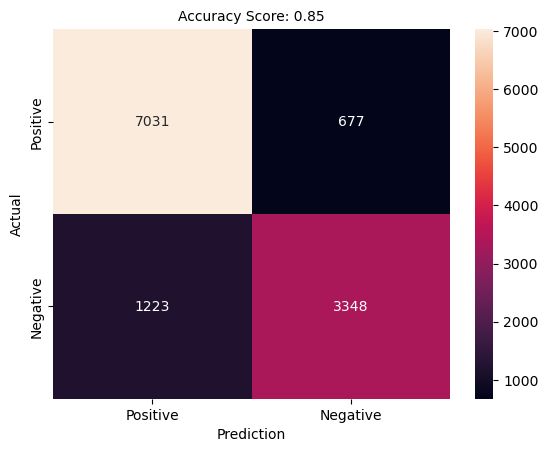

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      7708
           1       0.83      0.73      0.78      4571

    accuracy                           0.85     12279
   macro avg       0.84      0.82      0.83     12279
weighted avg       0.84      0.85      0.84     12279



In [17]:
sensitivity_cat, specificity_cat, accuracy_cat = plot_confusion_matrix(y_validate, y_pred_cat, "CatBoostClassifier")  # Capture the returned values

In [18]:
result_data

,Model_Name,Sensitivity,Specificity,Accuracy
0,Logistic Regression,0.649092,0.928775,0.82
1,CatBoostClassifier,0.732444,0.912169,0.85


### Evaluation with ROC and AUC - CatBoost Classifier - Baseline.

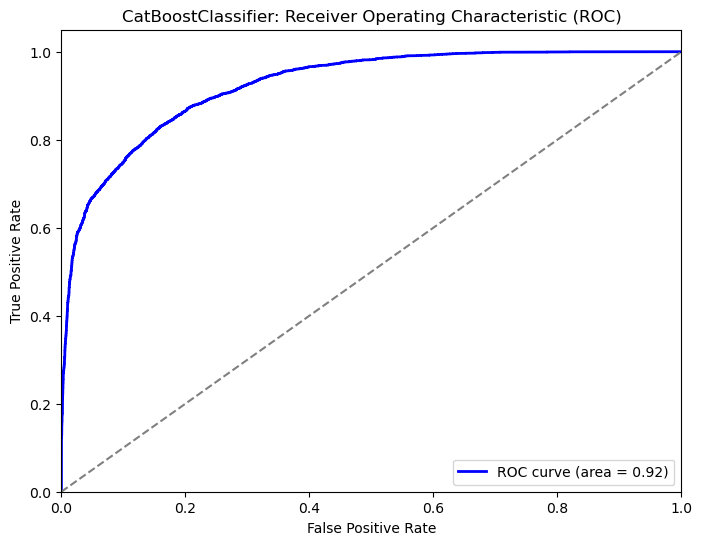

In [19]:
## ROC Visualization 
Modelname = "CatBoostClassifier"
y_pred_prob_cat = cat_model.predict_proba(X_validate)[:, 1]

# Generate the ROC 
fpr, tpr, thresholds = roc_curve(y_validate, y_pred_prob_cat)

# Calculate the Area Under Curve
roc_auc = roc_auc_score(y_validate, y_pred_prob_cat)

# Graph it all together.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{Modelname}: Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Tuning -  Optimize Model with Hyperparameter Tuning via Grid Search

## CatBoost


In [ ]:
#########################
#
#  STANDALONE TUNING  - CatBoost
# 
########################
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from tqdm import tqdm  # Import tqdm
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from catboost import Pool, CatBoostRegressor

### Define a Scorer for Grid Search
* Sensitivity and Specificity are both important aspects to optimize. 
* Want to find an balance between 'over categorizing' likely cases of PLOS (nursing effort) vs 'missing' and we revert to curernt state. 
* A balanced approach is being optimized in the `combined_score` and averages both equally. 
* Opportunity to refine based on operational preference. 

In [20]:
#########################
#
#  Scorer for GridSearch
# 
########################

from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def sensitivity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    return sensitivity

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])
    return specificity

def combined_score(y_true, y_pred):
    sens = sensitivity_score(y_true, y_pred)
    spec = specificity_score(y_true, y_pred)
    return (sens + spec) / 2

sensitivity_scorer = make_scorer(sensitivity_score, greater_is_better=True)
specificity_scorer = make_scorer(specificity_score, greater_is_better=True)
combined_scorer = make_scorer(combined_score, greater_is_better=True)

### CatBoost -  Perform GridSearch

In [21]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split


categorical_features_indices =[0, 2, 22,25, 26]


# Define the parameter grid to search
param_grid = {
    'iterations': [100, 200, 300],      # Number of boosting iterations
    'depth': [6, 8, 10],                # Depth of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate  
    }

scorers = {
    'sensitivity': sensitivity_scorer,
    'specificity': specificity_scorer,
    'combined':combined_scorer}

# Create a CatBoostRegressor model
catboost_model = CatBoostClassifier()

grid_search_cat = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring=scorers, refit='combined', cv=5, verbose=10,n_jobs=-1, error_score='raise')

grid_search_cat.fit(X_train, y_train, cat_features=categorical_features_indices)


# Print the best hyperparameters and corresponding MSE score
print("Best hyperparameters found:")
print(grid_search_cat.best_params_)
print("Best combined (Sensitivity & Specificity) score:", -grid_search_cat.best_score_)

# Get the best trained model
best_catboost_model = grid_search_cat.best_estimator_

# Evaluate the best model on the validation set
validation_predictions = best_catboost_model.predict(X_validate)

########################
## Output:
########################
'''Best hyperparameters found:
{'depth': 8, 'iterations': 200, 'learning_rate': 0.2}
Best combined (Sensitivity & Specificity) score: -0.8219980626026192
'''

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 0.5655919	total: 77.3ms	remaining: 15.4s
1:	learn: 0.4800670	total: 151ms	remaining: 14.9s
2:	learn: 0.4413290	total: 220ms	remaining: 14.4s
3:	learn: 0.4182379	total: 298ms	remaining: 14.6s
4:	learn: 0.3996549	total: 374ms	remaining: 14.6s
5:	learn: 0.3885536	total: 446ms	remaining: 14.4s
6:	learn: 0.3783066	total: 524ms	remaining: 14.5s
7:	learn: 0.3742259	total: 593ms	remaining: 14.2s
8:	learn: 0.3688192	total: 665ms	remaining: 14.1s
9:	learn: 0.3626071	total: 734ms	remaining: 14s
10:	learn: 0.3584281	total: 813ms	remaining: 14s
11:	learn: 0.3542604	total: 885ms	remaining: 13.9s
12:	learn: 0.3506691	total: 963ms	remaining: 13.9s
13:	learn: 0.3483017	total: 1.03s	remaining: 13.7s
14:	learn: 0.3464989	total: 1.11s	remaining: 13.7s
15:	learn: 0.3441790	total: 1.18s	remaining: 13.6s
16:	learn: 0.3435104	total: 1.26s	remaining: 13.5s
17:	learn: 0.3411142	total: 1.33s	remaining: 13.5s
18:	learn: 0.3403069	total: 1.41s

'Best hyperparameters found:\n'

### CatBoost - Train Model on Optimized Hyperparameters

In [29]:
#########################
#
#  OPTIMIZED - CatBoost
# 
########################

from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


###############
# Specify categorical feature indices
categorical_features_indices = [0, 2, 22,25, 26]


# Create the Pool for training data
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)

# If you have a validation dataset
validation_pool = Pool(data=X_validate, label=y_validate, cat_features=categorical_features_indices)

#########
# Best hyperparameters found (after hyperparameter tuning)
best_params = {'depth': 8, 'iterations': 200, 'learning_rate': 0.2}

# Instantiate CatBoostClassifier with the best hyperparameters
cat_model_opt = CatBoostClassifier(**best_params)

cat_model_opt.fit(
    train_pool,
    eval_set=validation_pool,  
    verbose=10,  # This will print the progress every 10 iterations
    plot=True    # This will plot the learning curve
)


y_pred_cat_r2 = cat_model_opt.predict(X_validate)  # If you used Pool, the data here should not be the Pool object but raw data.

# Calculate the Accruacy value
accuracy = accuracy_score(y_validate, y_pred_cat_r2)
print(f'Accuracy base model: {accuracy}')


########################
## Output:
########################
'''bestTest = 0.3349154585
bestIteration = 65

Shrink model to first 66 iterations.
Accuracy base model: 0.8468930694681978'''

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5655919	test: 0.5652751	best: 0.5652751 (0)	total: 85.6ms	remaining: 17s
10:	learn: 0.3584281	test: 0.3606474	best: 0.3606474 (10)	total: 856ms	remaining: 14.7s
20:	learn: 0.3381619	test: 0.3445610	best: 0.3445610 (20)	total: 1.71s	remaining: 14.6s
30:	learn: 0.3271102	test: 0.3392649	best: 0.3392649 (30)	total: 2.55s	remaining: 13.9s
40:	learn: 0.3208254	test: 0.3383908	best: 0.3383908 (40)	total: 3.37s	remaining: 13.1s
50:	learn: 0.3142457	test: 0.3364623	best: 0.3364623 (50)	total: 4.17s	remaining: 12.2s
60:	learn: 0.3080129	test: 0.3352699	best: 0.3352699 (60)	total: 5.02s	remaining: 11.4s
70:	learn: 0.3036631	test: 0.3349511	best: 0.3349155 (65)	total: 5.85s	remaining: 10.6s
80:	learn: 0.2991604	test: 0.3357292	best: 0.3349155 (65)	total: 6.67s	remaining: 9.79s
90:	learn: 0.2937264	test: 0.3357567	best: 0.3349155 (65)	total: 7.49s	remaining: 8.97s
100:	learn: 0.2884128	test: 0.3358937	best: 0.3349155 (65)	total: 8.35s	remaining: 8.18s
110:	learn: 0.2835323	test: 0.3360

'bestTest = 0.3349154585\nbestIteration = 65\n\nShrink model to first 66 iterations.\nAccuracy base model: 0.8468930694681978'

### Evaluate Optimized CatBoost Model

True labels:
116394    0
102011    0
11564     0
93856     1
47594     0
         ..
112235    0
14985     0
60829     0
95194     0
76465     0
Name: prolonged_LOS, Length: 12279, dtype: int64

Predicted labels:
[0 0 0 ... 0 0 0]


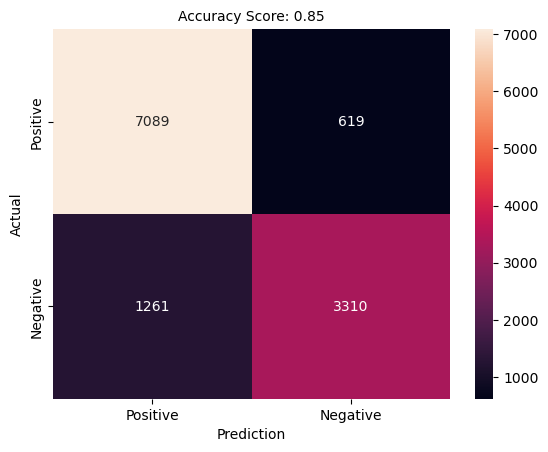

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      7708
           1       0.84      0.72      0.78      4571

    accuracy                           0.85     12279
   macro avg       0.85      0.82      0.83     12279
weighted avg       0.85      0.85      0.84     12279



In [30]:
sensitivity_cat_r2, specificity_cat_r2, accuracy_cat_r2 = plot_confusion_matrix(y_validate, y_pred_cat_r2, "CatBoostClassifier-Optimized")  # Capture the returned values

In [28]:
result_data

,Model_Name,Sensitivity,Specificity,Accuracy
0,Logistic Regression,0.649092,0.928775,0.82
1,CatBoostClassifier,0.732444,0.912169,0.85
2,CatBoostClassifier-Optimized,0.724130,0.919694,0.85


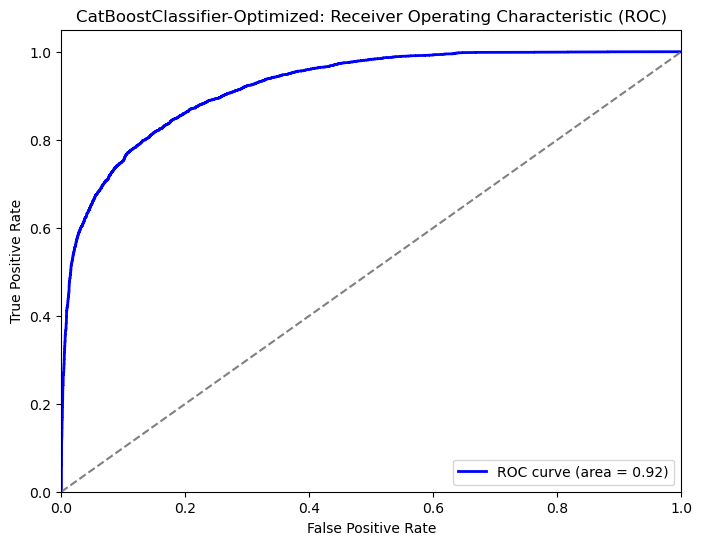

In [31]:
## ROC Visualization 
Modelname = "CatBoostClassifier-Optimized"
y_pred_cat_r2 = cat_model_opt.predict_proba(X_validate)[:, 1]

# Generate the ROC 
fpr, tpr, thresholds = roc_curve(y_validate, y_pred_cat_r2)

# Calculate the Area Under Curve
roc_auc = roc_auc_score(y_validate, y_pred_cat_r2)

# Graph it all together.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{Modelname}: Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Model Deployment


In [37]:
import pickle

with open('../_output/catboost_model_opt.pickle', 'wb') as f:
    pickle.dump(cat_model_opt, f)


else
